In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

## Setting seed for replication

In [38]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

AttributeError: module 'tensorflow' has no attribute 'Session'

## Constants

In [132]:
RESIZE_IMAGE_SIZE = (150, 150)
BATCH_SIZE = 16
EPOCHS = 25

## Loading the dataset

In [3]:
DATA_DIR = Path("./data/chest_xray/")

TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'

In [4]:
normal_train_dataset = TRAIN_DIR / 'NORMAL'
pneumonia_train_dataset = TRAIN_DIR / 'PNEUMONIA'

normal_test_dataset = TEST_DIR / 'NORMAL'
pneumonia_test_dataset = TEST_DIR / 'PNEUMONIA'

In [5]:
import cv2
from keras.utils import to_categorical

In [10]:
def parse_folder(dir, data, label):
    for img in dir.glob('*.jpeg'):
        try:
            data.append((img, label))
        except Exception as e:
            print('Error ', e)

In [11]:
def get_dataframe():
    data = []
    parse_folder(normal_train_dataset, data, False)
    parse_folder(pneumonia_train_dataset, data, True)
    train_dataset = pd.DataFrame(data, columns=['image', 'label'],index=None)
    #shuffle the dataset
    train_dataset = train_dataset.sample(frac=1.).reset_index(drop=True)

    return train_dataset

In [12]:
train_dataset = get_dataframe()
train_dataset.head(5)
print('Shape=',train_dataset.shape)

Shape= (5232, 2)


In [15]:
def parseImage(src):
    img_arr = cv2.imread(str(src))
    resized_img = cv2.resize(img_arr, RESIZE_IMAGE_SIZE)
    return resized_img

## Analysis 

### Distribution of training data

In [17]:
import seaborn as sns

True     3883
False    1349
Name: label, dtype: int64


([<matplotlib.axis.XTick at 0x23db008c610>,
 [Text(0, 0, 'Normal'), Text(0, 0, 'Pneumonia')])

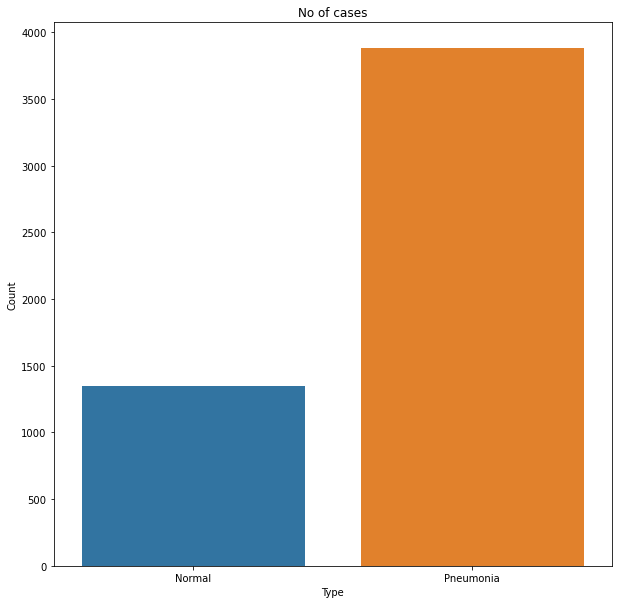

In [18]:
distribution = train_dataset['label'].value_counts()
print(distribution)

plt.figure(figsize=(10, 10))
sns.barplot(x=distribution.index, y=distribution.values)
plt.title('No of cases')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(range(len(distribution)), ['Normal', 'Pneumonia'])

### Correcting Imbalance

In [19]:
# we will try to correct this imbalance by assigning more weight to normal datasets than pneumonia ones
count_pnemonia = distribution[True]
count_normal = distribution[False]
count_total = len(train_dataset)
initial_bias = np.log([count_pnemonia/count_normal])
print('Initial bias = ', initial_bias)

Initial bias =  [1.05724447]


In [20]:
weight_for_normal = ((1 / count_normal)*count_total) / 2.0 
weight_for_pneumonia = ((1 / count_pnemonia)*count_total) / 2.0

class_weight = {False: weight_for_normal, True: weight_for_pneumonia}

print('Weight for class normal: {:.2f}'.format(weight_for_normal))
print('Weight for class pneumonia: {:.2f}'.format(weight_for_pneumonia))

Weight for class normal: 1.94
Weight for class pneumonia: 0.67


## Visualization

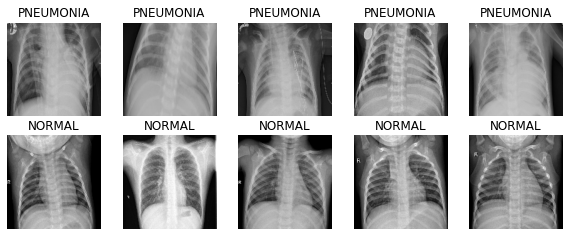

In [22]:
pneumonia_samples = (train_dataset[train_dataset['label']==True]['image'].iloc[:5]).tolist()
normal_samples = (train_dataset[train_dataset['label']==False]['image'].iloc[:5]).tolist()

samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
plt.figure(figsize=(10,10))
for n in range(10):
    img = parseImage(samples[n])
    ax = plt.subplot(5,5,n+1)
    plt.imshow(img)
    if n < 5:
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
    plt.axis("off")

## Building the model

In [23]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [24]:
def conv_layer(filters):
    block = tf.keras.Sequential([
        Conv2D(filters, (3,3), activation='relu', padding='same' ),
        Conv2D(filters, (3,3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D()
    ])
    
    return block
    
def dense_layer(units, dropout_rate):
    block = tf.keras.Sequential([
        Dense(units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])
    
    return block

In [129]:
model = Sequential([
    Input(shape=(RESIZE_IMAGE_SIZE[0], RESIZE_IMAGE_SIZE[1], 3)),
    
    Conv2D(16, 3, activation='relu', padding='same'),
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPool2D(),
    
    conv_layer(32),
    conv_layer(64),    
    conv_layer(128),
    Dropout(0.2),
    
    conv_layer(256),
#     MaxPool2D(),
    Dropout(0.2),
    
    Flatten(),
    dense_layer(512, 0.7),
    dense_layer(128, 0.5),
    dense_layer(64, 0.3),
    
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_163 (Conv2D)          (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 75, 75, 16)        0         
_________________________________________________________________
sequential_132 (Sequential)  (None, 37, 37, 32)        14016     
_________________________________________________________________
sequential_133 (Sequential)  (None, 18, 18, 64)        55680     
_________________________________________________________________
sequential_134 (Sequential)  (None, 9, 9, 128)         221952    
_________________________________________________________________
dropout_78 (Dropout)         (None, 9, 9, 128)      

In [101]:
train_datagen = ImageDataGenerator(
        rescale = 1/255,
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30, 
        zoom_range = 0.2, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip = False,
        vertical_flip=False
    )

test_datagen = ImageDataGenerator(rescale=1./255)

In [102]:
train_generator = train_datagen.flow_from_directory(
                    'data/chest_xray/train',
                    target_size=RESIZE_IMAGE_SIZE,
                    batch_size=BATCH_SIZE,
                    class_mode='binary'
                )

test_generator = test_datagen.flow_from_directory(
                    'data/chest_xray/test',
                    target_size=RESIZE_IMAGE_SIZE,
                    batch_size=BATCH_SIZE,
                    class_mode='binary'
                )

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [130]:
optimizer = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')], 
              optimizer=optimizer)

# Define the number of training steps
no_train_steps = train_dataset.shape[0]//BATCH_SIZE

### Fine tuning

In [120]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

## Training

In [133]:
history = model.fit(
                    train_generator, #image_gen.flow(x_train,y_train, batch_size = 32),
                    epochs=EPOCHS, 
                    steps_per_epoch=no_train_steps,
                    validation_data=test_generator, #(valid_data, valid_labels),     
                    callbacks=[es, chkpt, lr_scheduler],
                    class_weight=class_weight)

Epoch 1/25
327/327 [==============================] - 159s 485ms/step - loss: 0.3869 - accuracy: 0.8297 - precision: 0.9372 - recall: 0.8259 - val_loss: 2.5291 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/25
327/327 [==============================] - 159s 487ms/step - loss: 0.3445 - accuracy: 0.8515 - precision: 0.9525 - recall: 0.8419 - val_loss: 1.2663 - val_accuracy: 0.6266 - val_precision: 0.6264 - val_recall: 0.9974 - lr: 0.0089
Epoch 3/25
327/327 [==============================] - 159s 485ms/step - loss: 0.3084 - accuracy: 0.8597 - precision: 0.9562 - recall: 0.8499 - val_loss: 1.7018 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000 - lr: 0.0079
Epoch 4/25
327/327 [==============================] - 159s 486ms/step - loss: 0.2827 - accuracy: 0.8825 - precision: 0.9647 - recall: 0.8736 - val_loss: 0.9045 - val_accuracy: 0.7131 - val_precision: 0.6874 - val_recall: 0.9923 - lr: 0.0071
Epoch 5/25
327/327 [================

## Visualize performance

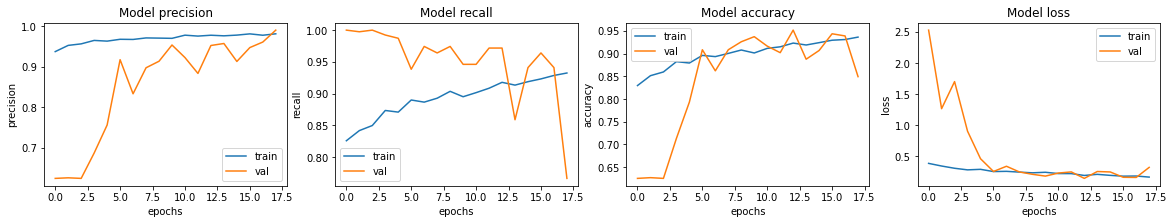

In [134]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])